En este notebook implementamos los modelos

In [1]:
import torch.optim as optim
import torch
from sklearn.metrics import *
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.init as init
import importlib
import kagglehub
import data
import agente
import torch
import torch.nn as nn
import torch.nn.functional as F
from itertools import islice
importlib.reload(data)
importlib.reload(agente)

c:\Users\Adrian\anaconda3\envs\AA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'agente' from 'd:\\Universidad\\Aprendizaje-Automatico-y-Big-Data\\Practica5\\agente.py'>

In [90]:
#Aqui habría que poner la linea de codigo para descargar el dataset
#El dataset tiene un par de fotos en los que el formato del nombre de la imagen esta mal; yo las he borrado directamente pero en google colab no se puedem borrar archivos
#por eso no he puesto el codigo de la descarga
#Cuando hagas pruebas tu carga el dataset entero en dataset = data.ImgDataset(utk_ruta,transform=transform) y cuando los tengas cargados quita las foto de dataset que den problemas
#Son aquellas que eran de la forma edad_año_fecha.jpg


In [2]:
#solo sirve en mi ordena ichi esta linea
utk_ruta = "C:\\Users\\Adrian\\.cache\\kagglehub\\datasets\\jangedoo\\utkface-new\\versions\\1\\UTKFace"

# Transformar dataset 
Transformamos las imagenes en una estructura de datos con la que podamos trabajar

In [3]:
#Adaptamos las imagenes a un dataset
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #Esto normalizara las imagenes
dataset = data.ImgDataset(utk_ruta,transform=transform) #Pasamos las imagenes a la estructura de datos

GENERO = ('Hombre','Mujer')
RAZA = ('Blanco','Negrata','Chinito','Indio','Otros')


In [4]:
# Crear los DataLoaders
train_dataloader,test_dataloader = data.entrenamientoTest(dataset=dataset,test_size=0.2,batch_size=4)

print(len(train_dataloader))
print(len(test_dataloader))

4741
1186


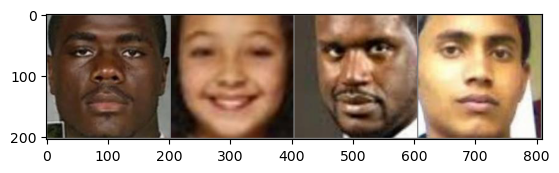

Edad:    22.0  10.0  31.0  18.0
Genero: Hombre Mujer Hombre Hombre
Raza:   Negrata Otros Negrata Indio


In [5]:
# Display image and label.
imagenes, edades,generos,razas = next(iter(train_dataloader))

# show images
data.mostrarImg(imagenes)
print('Edad:  ',' '.join('%5s' % edades[j].item() for j in range(4)))
print('Genero:',' '.join('%5s' % GENERO[generos[j].item()] for j in range(4)))
print('Raza:  ',' '.join('%5s' % RAZA[razas[j].item()] for j in range(4)))


In [ ]:
def graficaEntrenamiento(train_loss,train_accuracy,test_loss,test_accuracy,epochs,nombre):
    x1 = np.arange(0,epochs)
    x2 = np.arange(0,epochs+1,5)

    
    fig,axs = plt.subplots(1,2)

    #Loss
    axs[0].plot(x1,train_loss,label = "Train Loss", color = 'b')
    axs[0].plot(x2,test_loss,label = "Test Loss", color = 'r')
    axs[0].set_title('Loss')  # Título del primer gráfico
    axs[0].set_xlabel('Epochs')  # Etiqueta del eje X
    axs[0].set_ylabel('Loss')  # Etiqueta del eje Y
    axs[0].legend()
    axs[0].grid(True)

    #Train
    axs[1].plot(x1,train_accuracy,label = "Train Acurracy", color = 'b')
    axs[1].plot(x2,test_accuracy,label = "Test Acurracy", color = 'r')
    axs[1].set_title('Accuracy')  # Título del primer gráfico
    axs[1].set_xlabel('Epochs')  # Etiqueta del eje X
    axs[1].set_ylabel('Acurracy')  # Etiqueta del eje Y
    axs[1].legend()
    axs[1].grid(True)
    
    plt.grid(True)
    plt.tight_layout()  # Ajusta el espaciado entre los subgráficos
    plt.savefig(f'.//Graficas//{nombre}')


# Modelo 1: Denzel Washington

Entrenaremos 3 modelos distintos, uno por cada objetivo que queremos predecir. 

Ambos modelos tendrán la misma estructura excepto en la ultima capa. 

Además el entrenamiento será distinto para cada uno de ellos pues utilizaremos distintos criterios y optimizadores segun el objetivo

In [7]:
class DenzelWashington(nn.Module):
    def __init__(self,output_layers):
        super().__init__()

        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.pool2 = nn.MaxPool2d(4, 4)
       
        self.fc1 = nn.Linear(12 * 11 * 11, 500)
        self.fcout = nn.Linear(500, output_layers)

        self.apply(self._init_weights)  # Aplicar la inicialización de pesos

    def _init_weights(self, m):
        """Inicializa los pesos de la red"""
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            init.normal_(m.weight, mean=0.0, std=0.02)
            if m.bias is not None:
                init.constant_(m.bias, 0)

    def forward(self, x):

        x = self.pool1(x) #3 fotos 100x100
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.fcout(x)
        return x




In [8]:
#Esto sirve para ver en que dispositivo se entrena.
#GPU(cuda) es mas rapido que CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Entrenando en: {device}")

Entrenando en: cuda


Creamos un agente con los 3 modelos siguientes:

In [96]:
#Modelo edad
DWEdad = DenzelWashington(output_layers=1).to(device)
mseLoss = nn.MSELoss()

#Modelo Genero
DWGenero = DenzelWashington(output_layers=2).to(device)
entropyLossGen = nn.CrossEntropyLoss()

#Modelo raza
DWRaza = DenzelWashington(output_layers=5).to(device)
entropyLossRaza = nn.CrossEntropyLoss()

agenteDW = agente.Agente(modeloEdad=DWEdad,
                         modeloGenero=DWGenero,
                         modeloRaza=DWRaza,
                         criterioEdad=mseLoss,
                         criterioGenero=entropyLossGen,
                         criterioRaza=entropyLossRaza,
                         device=device,
                         lr = 0.0001)


- Genero : 20 epochs

In [ ]:
train_loss_Genero,train_accuracy_Genero,test_loss_Genero,test_accuracy_Genero = agenteDW.entrenarModelo(train_dataloader,test_dataloader,"Genero",num_epochs=20)

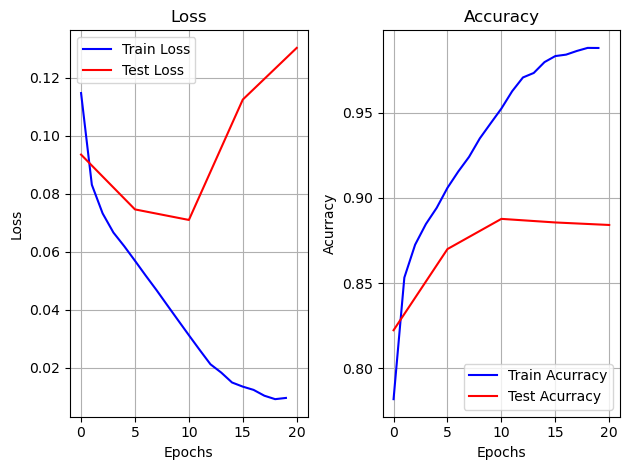

In [53]:
np.savez('entrenamientoGeneroDW.npz', a=np.array(train_loss_Genero), b=np.array(train_accuracy_Genero),c =np.array(test_loss_Genero), d = np.array(test_accuracy_Genero) )
torch.save(agenteDW.modeloGenero.state_dict(), './/Modelos//DWGenero3.pth')
graficaEntrenamiento(train_loss_Genero,train_accuracy_Genero,test_loss_Genero,test_accuracy_Genero,epochs= 20,nombre="entrenamientoGeneroDW")

- Edad: 150 epochs 

In [ ]:
train_loss_Edad,train_accuracy_Edad,test_loss_Edad,test_accuracy_Edad = agenteDW.entrenarModelo(train_dataloader,test_dataloader,"Edad",num_epochs=150)

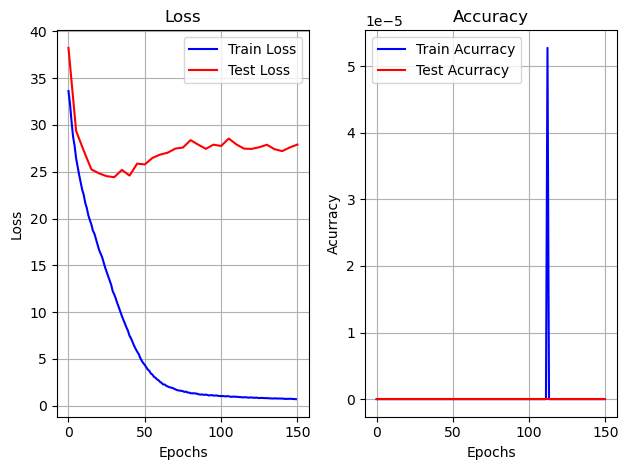

In [ ]:
np.savez('entrenamientoEdadDW.npz', a=np.array(train_loss_Edad), b=np.array(train_accuracy_Edad),c =np.array(test_loss_Edad), d = np.array(test_accuracy_Edad) )
graficaEntrenamiento(train_loss_Edad,train_accuracy_Edad,test_loss_Edad,test_accuracy_Edad,epochs=150,nombre="entrenamientoEdadDW")
torch.save(agenteDW.modeloEdad.state_dict(), './/Modelos//DWEdad3.pth')

- Raza: 30 epochs

In [ ]:
train_loss_Raza,train_accuracy_Raza,test_loss_Raza,test_accuracy_Raza = agenteDW.entrenarModelo(train_dataloader,test_dataloader,"Raza",num_epochs=30)

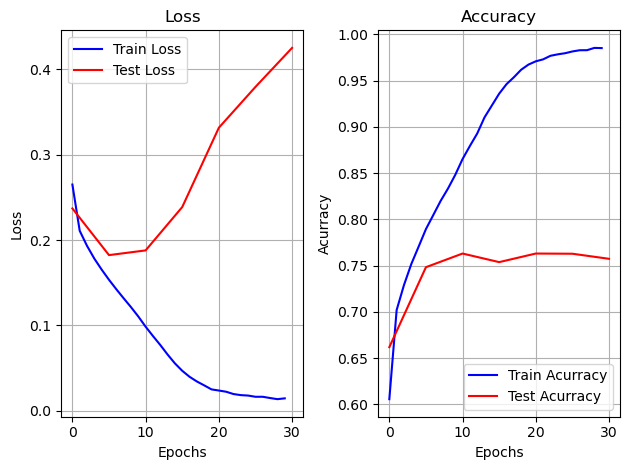

In [99]:
np.savez('entrenamientoRazaDW.npz', a=np.array(train_loss_Raza), b=np.array(train_accuracy_Raza),c =np.array(test_loss_Raza), d = np.array(test_accuracy_Raza) )
graficaEntrenamiento(train_loss_Raza,train_accuracy_Raza,test_loss_Raza,test_accuracy_Raza,epochs=30,nombre="entrenamientoRazaDW")
#torch.save(agenteDW.modeloRaza.state_dict(), './/Modelos//DWRaza3.pth')

In [104]:
agenteDW.modeloEdad.load_state_dict(torch.load('./Modelos/DWEdad3.pth'))
agenteDW.modeloGenero.load_state_dict(torch.load('./Modelos/DWGenero3.pth'))
agenteDW.modeloRaza.load_state_dict(torch.load('./Modelos/DWRaza3.pth'))

<All keys matched successfully>

# Resultados


In [105]:
edadesTotal,edadesPredTotal,generosTotal,generosPredTotal,razasTotal,razasPredTotal = agenteDW.resultados(test_dataloader)

In [106]:
metricasGenero = classification_report(generosTotal, generosPredTotal,target_names=GENERO)
metricasRaza = classification_report(razasTotal, razasPredTotal,target_names=RAZA)
print(metricasGenero)
print(metricasRaza)


              precision    recall  f1-score   support

      Hombre       0.89      0.89      0.89      2483
       Mujer       0.88      0.88      0.88      2259

    accuracy                           0.88      4742
   macro avg       0.88      0.88      0.88      4742
weighted avg       0.88      0.88      0.88      4742

              precision    recall  f1-score   support

      Blanco       0.80      0.83      0.82      1969
     Negrata       0.80      0.82      0.81       892
     Chinito       0.85      0.75      0.80       708
       Indio       0.66      0.74      0.70       835
       Otros       0.40      0.29      0.34       338

    accuracy                           0.76      4742
   macro avg       0.70      0.69      0.69      4742
weighted avg       0.76      0.76      0.76      4742



In [107]:
print("Tasa de aciertos de la red en EDAD: ",accuracy_score(edadesTotal, edadesPredTotal)*100, "%")


Tasa de aciertos de la red en EDAD:  4.555040067482075 %


El modelo no es capaz de determinar la edad exacta ¿ pero cuanto se equivoca? Error absoluto medio 

In [108]:
print(f'Error absoluto medio(Edad): {mean_absolute_error(edadesTotal, edadesPredTotal)}')

Error absoluto medio(Edad): 7.6895824546604805


- Matriz confusion

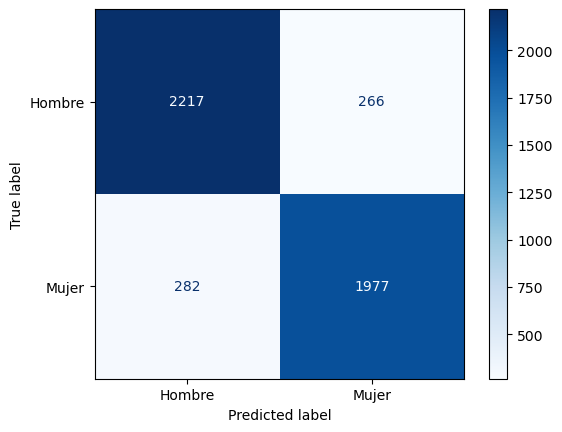

In [109]:
matrizGenero = confusion_matrix(generosTotal, generosPredTotal)
disp = ConfusionMatrixDisplay(confusion_matrix=matrizGenero,display_labels=GENERO)
disp.plot(cmap = plt.cm.Blues)
plt.show()

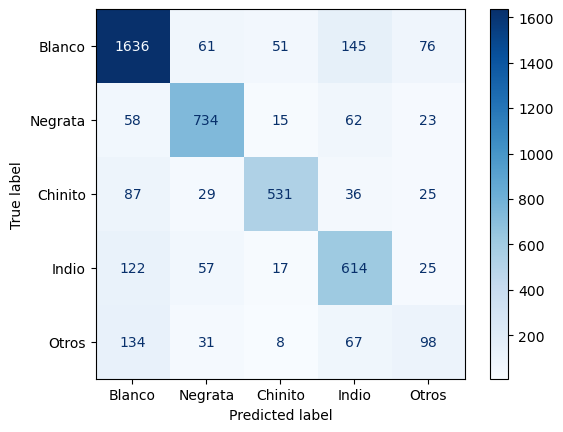

In [110]:
matrizRaza = confusion_matrix(razasTotal, razasPredTotal)
disp = ConfusionMatrixDisplay(confusion_matrix=matrizRaza,display_labels=RAZA)
disp.plot(cmap = plt.cm.Blues)
plt.show()

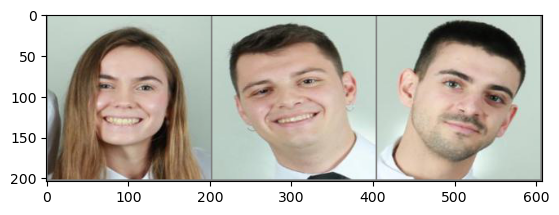

Genero Real: Mujer Hombre Hombre
Genero Pred: Mujer Hombre Hombre
Edad Real:  23.0  24.0  24.0
Edad Pred:    17    37    65
Raza Real: Blanco Blanco Blanco
Raza Pred: Negrata Blanco Blanco


In [94]:
tempusFugit = data.ImgDataset("./fotos",transform=transform)
imagenes = [imagen for imagen, _, _,_ in tempusFugit ]
edades = [edad for _,edad,_,_ in tempusFugit]
generos = [genero for _,_, genero,_ in tempusFugit]
razas = [raza for _,_,_,raza in tempusFugit]

data.mostrarImg(imagenes)
imagenes = torch.stack(imagenes,dim = 0).to(device)
edades = torch.stack(edades,dim=0)
generos = torch.stack(generos,dim=0)
razas = torch.stack(razas,dim=0)

generosPred = agenteDW.modeloGenero(imagenes)
razasPred = agenteDW.modeloRaza(imagenes)
edadesPred= agenteDW.modeloEdad(imagenes)  

_, generosPred = torch.max(generosPred, 1)
_, razasPred = torch.max(razasPred, 1)


print('Genero Real:',' '.join('%5s' % GENERO[generos[j].item()] for j in range(3)))
print('Genero Pred:',' '.join('%5s' % GENERO[generosPred[j].item()] for j in range(3)))

print('Edad Real:',' '.join('%5s' % edades[j].item() for j in range(3)))
print('Edad Pred:',' '.join('%5s' % int(edadesPred[j].item()) for j in range(3)))

print('Raza Real:',' '.join('%5s' % RAZA[razas[j].item()] for j in range(3)))
print('Raza Pred:',' '.join('%5s' % RAZA[razasPred[j].item()] for j in range(3)))


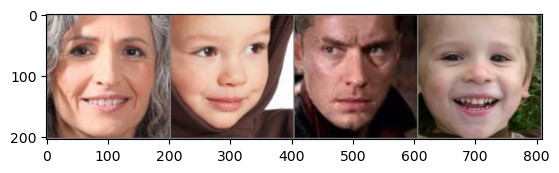

Genero Real: Mujer Hombre Hombre Hombre
Genero Pred: Mujer Hombre Hombre Mujer
Edad Real:  60.0   3.0  48.0   4.0
Edad Pred:    44    20    45     0
Raza Real: Blanco Blanco Blanco Blanco
Raza Pred: Indio Chinito Blanco Blanco


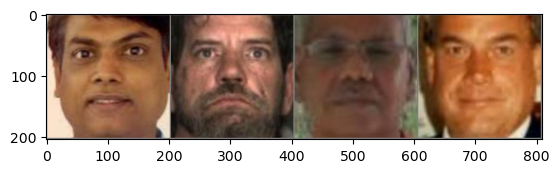

Genero Real: Hombre Hombre Hombre Hombre
Genero Pred: Hombre Hombre Hombre Hombre
Edad Real:  28.0  57.0  60.0  55.0
Edad Pred:    25    48    55    48
Raza Real: Indio Blanco Indio Blanco
Raza Pred: Indio Blanco Blanco Blanco


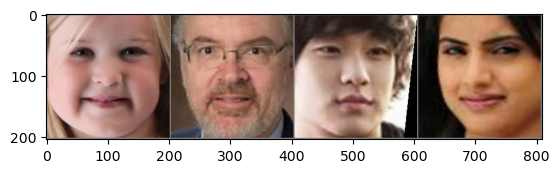

Genero Real: Mujer Hombre Hombre Mujer
Genero Pred: Mujer Hombre Hombre Mujer
Edad Real:   5.0  65.0  26.0  27.0
Edad Pred:    14    64    12    30
Raza Real: Blanco Blanco Chinito Indio
Raza Pred: Blanco Blanco Chinito Indio


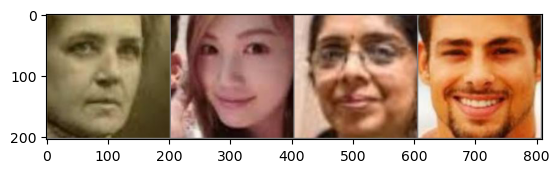

Genero Real: Mujer Mujer Mujer Hombre
Genero Pred: Mujer Mujer Mujer Hombre
Edad Real:  35.0  30.0  56.0  23.0
Edad Pred:    48    21    42    22
Raza Real: Blanco Chinito Indio Blanco
Raza Pred: Blanco Chinito Indio Otros


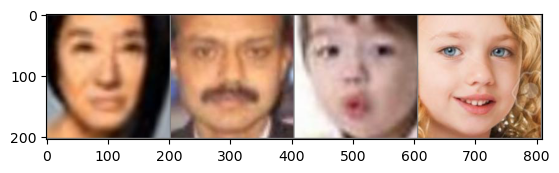

Genero Real: Mujer Hombre Hombre Mujer
Genero Pred: Mujer Hombre Mujer Mujer
Edad Real:  60.0  26.0   4.0   6.0
Edad Pred:    28    44     8     1
Raza Real: Blanco Indio Chinito Blanco
Raza Pred: Chinito Indio Chinito Blanco


In [111]:
for batch in islice(test_dataloader,5):
    imagenes, edades,generos,razas = batch
    imagenes = imagenes.to(device)
    

    data.mostrarImg(imagenes)
    generosPred = agenteDW.modeloGenero(imagenes)
    razasPred = agenteDW.modeloRaza(imagenes)

    edadesPred= agenteDW.modeloEdad(imagenes)  

    _, generosPred = torch.max(generosPred, 1)
    _, razasPred = torch.max(razasPred, 1)


    print('Genero Real:',' '.join('%5s' % GENERO[generos[j].item()] for j in range(4)))
    print('Genero Pred:',' '.join('%5s' % GENERO[generosPred[j].item()] for j in range(4)))

    print('Edad Real:',' '.join('%5s' % edades[j].item() for j in range(4)))
    print('Edad Pred:',' '.join('%5s' % int(edadesPred[j].item()) for j in range(4)))

    print('Raza Real:',' '.join('%5s' % RAZA[razas[j].item()] for j in range(4)))
    print('Raza Pred:',' '.join('%5s' % RAZA[razasPred[j].item()] for j in range(4)))
 

    

# Modelo 2: Lola Lolita

In [112]:
class LolaLolita(nn.Module):
    def __init__(self,output_layers):
        super().__init__()

        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(6, 12, 4)
        self.conv3 = nn.Conv2d(12,24,6)
        self.conv4 =  nn.Conv2d(24,48,16)
        self.pool2 = nn.MaxPool2d(3, 3)
       
        self.fc1 = nn.Linear(48 * 100, 1200)
        self.fc2 = nn.Linear(1200, 850)
        self.fcout = nn.Linear(850, output_layers)

        self.apply(self._init_weights)  # Aplicar la inicialización de pesos

    def _init_weights(self, m):
        """Inicializa los pesos de la red"""
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            init.normal_(m.weight, mean=0.0, std=0.02)
            if m.bias is not None:
                init.constant_(m.bias, 0)

    def forward(self, x):

        x = self.pool1(x) 
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(F.relu(self.conv3(x)))
        x = self.pool2(F.relu(self.conv4(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fcout(x)
        return x

In [113]:
#Esto sirve para ver en que dispositivo se entrena.
#GPU(cuda) es mas rapido que CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Entrenando en: {device}")

Entrenando en: cuda


In [115]:
a  = 0.0001
#Modelo edad
LLEdad = LolaLolita(output_layers=1).to(device)
mseLoss = nn.MSELoss()

#Modelo Genero
LLGenero = LolaLolita(output_layers=2).to(device)
entropyLossGen = nn.CrossEntropyLoss()

#Modelo raza
LLRaza = LolaLolita(output_layers=5).to(device)
entropyLossRaza = nn.CrossEntropyLoss()

agenteLL= agente.Agente(modeloEdad=LLEdad,
                         modeloGenero=LLGenero,
                         modeloRaza=LLRaza,
                         criterioEdad=mseLoss,
                         criterioGenero=entropyLossGen,
                         criterioRaza=entropyLossRaza,
                         device=device,
                         lr = 0.00001)

- Genero

In [ ]:
train_loss_Genero,train_accuracy_Genero,test_loss_Genero,test_accuracy_Genero = agenteDW.entrenarModelo(train_dataloader,test_dataloader,"Genero",num_epochs=20)

In [ ]:
#Este codigo es solo de prueba
train_loss,train_accuracy,test_loss,test_accuracy = [],[],[],[]

for i in range(4):
    run_train_loss,run_train_accuracy,run_test_loss,run_test_accuracy = agenteLL.entrenarModelo(train_dataloader,test_dataloader,"Genero",num_epochs=5)
    
    train_loss += run_train_loss
    train_accuracy +=run_train_accuracy
    test_loss +=run_test_loss
    test_accuracy +=run_test_accuracy

    graficaEntrenamiento(train_loss,train_accuracy,test_loss,test_accuracy,epochs=(5*(i+1)),nombre="entrenamientoGeneroLL")
    np.savez('entrenamientoGeneroLL.npz', a=np.array(train_loss), b=np.array(train_accuracy),c =np.array(test_loss), d = np.array(test_accuracy) )
   

In [ ]:
graficaEntrenamiento(train_loss,train_accuracy,test_loss,test_accuracy,epochs=20,nombre="entrenamientoGeneroLL")